# Praca domowa 6
Naszym zadaniem jest przeprowadzenie redukcji wymiarów danych oraz zbadanie w jaki sposób modyfikacje zdjęć wpływają na redukcję wymiarów

In [69]:
from sklearn.datasets import fetch_olivetti_faces
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

# Zbiór danych
Nasz zbiór danych zawiera dane w formie macierzy numpyowych, jak również w formie jednego długiego wektora o wymiarach (1,4096). 

In [261]:
def plot_gallery(images, title="", n_col=3, n_row=2, cmap=plt.cm.gray):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i+ 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(64, 64), cmap='gray')
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0)
                        
faces = fetch_olivetti_faces(shuffle=True)
images = faces['images']
data =  faces['data']

Tak wygląda 6 pierszych zdjęć z naszego zbioru 

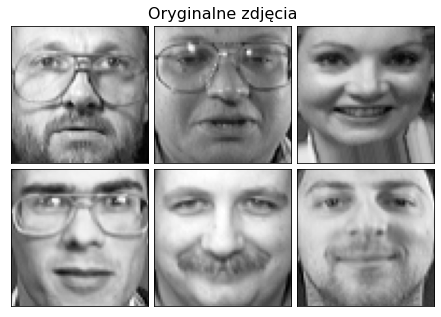

In [262]:
plot_gallery(images[:6], title="Oryginalne zdjęcia")

In [242]:
pca = PCA()
transformed = pca.fit_transform(data)
transformed.shape

(400, 400)

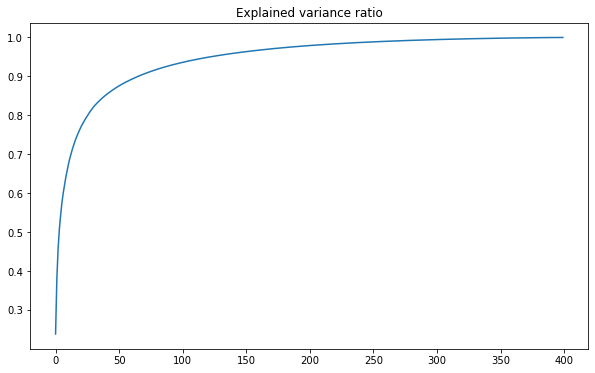

In [243]:
plt.figure(1, figsize=(10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("Explained variance ratio")
plt.show()

Widzimy że gwałtowny spadek wyjaśnialnej wariancji następuję gdzieś przy 50 wymiarach. Spróbujmy wybrać tyle wymiarów aby wyjaśnić 80% wariancji.

In [244]:
pca = PCA(n_components=0.85)
transformed = pca.fit_transform(data)
transformed.shape
print("Stopień kompresji: ", 4096/transformed.shape[1])

Stopień kompresji:  102.4


Stopień kompresji jest równy mniej więcej 102 i jest to całkiem imponujący wynik. Zobaczmy jak będą wyglądać nasze zdjęcia po tak znacznej redókcji wymiarów.

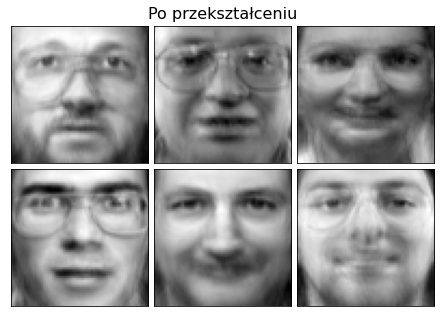

In [266]:
data_rt = pca.inverse_transform(transformed)
plot_gallery(data_rt[:6], title = "Po przekształceniu")


Zdjęcia są dużo mniej wyraźne i jakby pomieszane ale dalej da się rozpoznać konkretne osoby 

In [267]:
def mean_RMSE(oryginal, trans):
    rmse = 6 * [0]
    for i in range(6):
        rmse[i] = (mean_squared_error(oryginal[i], trans[i], squared=False))
    return np.mean(rmse)

In [268]:
print("Średna błędów średnokwadratowych: ", mean_RMSE(row_data, data_rt))


Średna błędów średnokwadratowych:  0.055080358


Dla niezmodyfikowanych obrazków średni błąd kwadratowy wyniosi 0.055. Będzie to nasz punkt odniesienia dla zmodyfikowanych orazków

# Modyfikacje
Kolejnym etapem jest przeprowadzenie modyfikacji i sprawdzenie jak wpłynie ona na rekonstrukcję wszystkich wymiarów.
## Rotacje 

### Góra dół

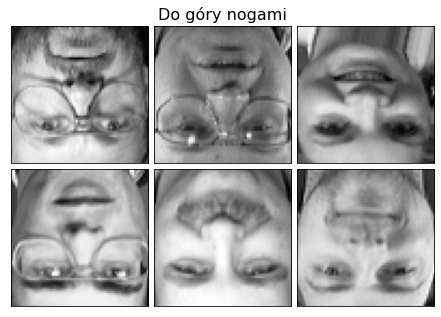

In [269]:
updown = 6 * [0]
for i in range(6):
    updown[i] = np.flipud(images[i])
plot_gallery(updown, title = "Do góry nogami")


Średna błędów średnokwadratowych:  0.116777174


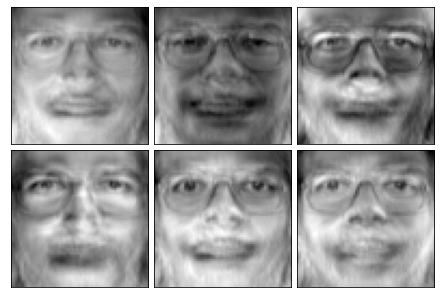

In [270]:
def compare_RMSE(mod):
    mod = np.array(mod).reshape(6, -1)
    transformed_data  = pca.transform(mod)
    inverted = pca.inverse_transform(transformed_data)
    plot_gallery(inverted[:6])
    return mean_RMSE(mod, inverted)

print("Średna błędów średnokwadratowych: ", compare_RMSE(updown))

### Lewo prawo 

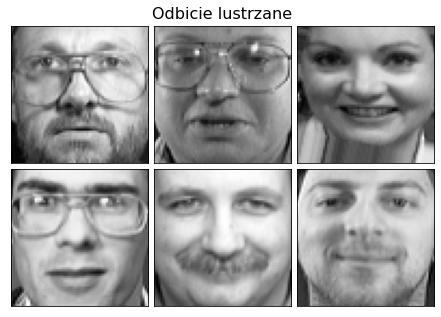

In [271]:
lfrght = 6 * [0]
for i in range(6):
    lfrght[i] = np.fliplr(images[i])
plot_gallery(lfrght, title = "Odbicie lustrzane")

Średna błędów średnokwadratowych:  0.076136


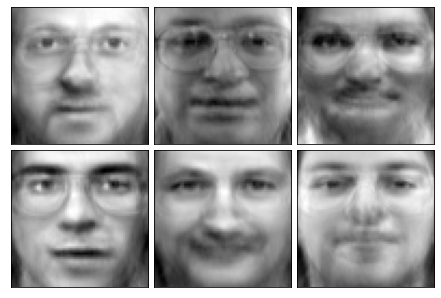

In [272]:
print("Średna błędów średnokwadratowych: ", compare_RMSE(lfrght))

### O dany kąt 

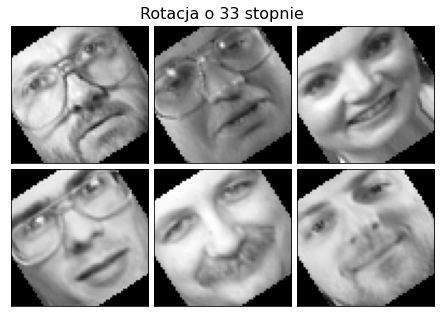

In [275]:
rotate = 6 * [0]
for i in range(6):
    rotate[i] = ndimage.rotate(images[i] , 33, reshape=False)
plot_gallery(rotate, title = "Rotacja o 33 stopnie")


Średna błędów średnokwadratowych:  0.16866939


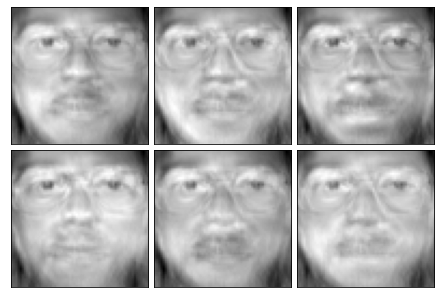

In [276]:
print("Średna błędów średnokwadratowych: ", compare_RMSE(rotate))

## Rozmazywanie

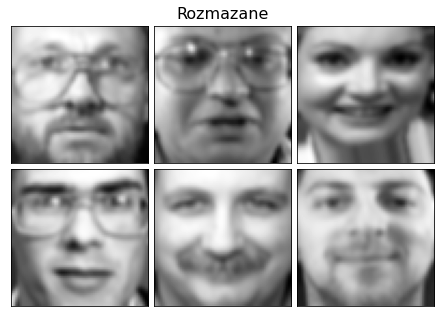

In [277]:
blurred = 6 * [0]
for i in range(6):
    blurred[i] = ndimage.gaussian_filter(images[i] , sigma=1)
plot_gallery(blurred, title = "Rozmazane")

Średna błędów średnokwadratowych:  0.037723135


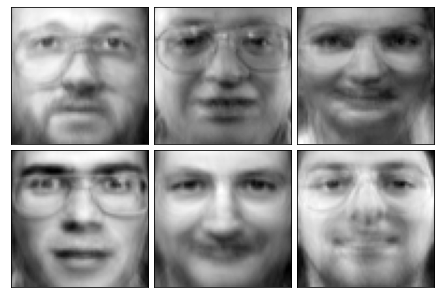

In [278]:
print("Średna błędów średnokwadratowych: ", compare_RMSE(blurred))

## Rozjaśnianie

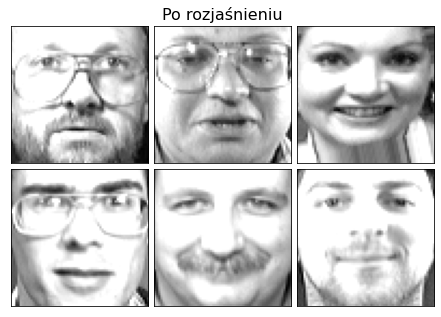

In [279]:
def rozjasnianie(image, k):
    im = k * image
    im[im > 1] = 1
    return im

lightup = 6 * [0]
for i in range(6):
    lightup[i] = rozjasnianie(images[i], 1.5)
plot_gallery(lightup, title = "Po rozjaśnieniu")

Średna błędów średnokwadratowych:  0.08244599


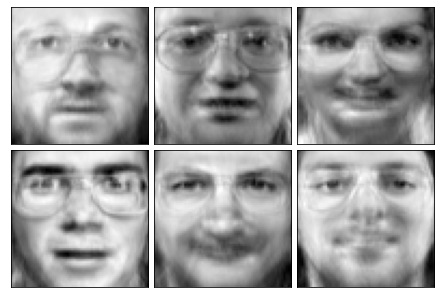

In [280]:
print("Średna błędów średnokwadratowych: ", compare_RMSE(lightup))

## Zciemnianie

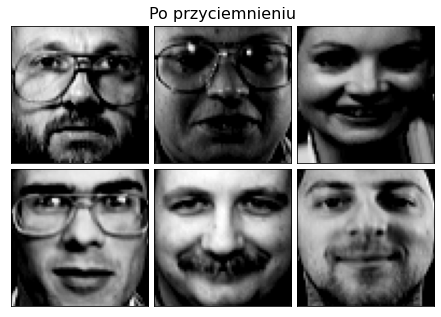

In [281]:
def rozjasnianie(image, k):
    im = image - k
    im[im < 0] = 0
    return im

darkening = 6 * [0]
for i in range(6):
    darkening[i] = rozjasnianie(images[i], 0.4)
plot_gallery(darkening, title = "Po przyciemnieniu")

Średna błędów średnokwadratowych:  0.06301149


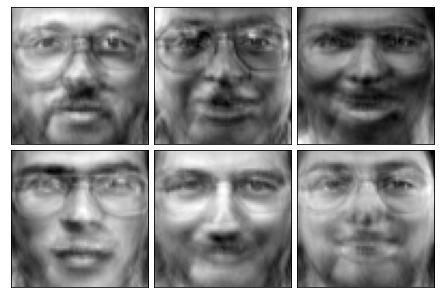

In [282]:
print("Średna błędów średnokwadratowych: ", compare_RMSE(darkening))

## Porównanie i wnioski 
Prawie wszystkie modyfikacje uzyskały wyższy błąd średniokwadratowy. Wyjątkiem było rozmazywanie zdjęć. Tytaj błąd RMSE spadł. Największy błąd uzyskały rotacje. Co ciekawe miały one większy błąd niż obrót względem osi poziomej. Obrót względem osi pionowej nie zrobił dużej róznicy w błędzie. Wynika to za pewne z tego że ludzkie twarze są mniej więcej symetryczne. Zmiana jasności również uzyskała podobne wyniki co niezmienione zdjęcia. Jeśli chodzi o wykrywanie pewnych anomali to można by było wykrywać właśnie rozmazane twarzę po niskim błędzie. Z drugiej strony PCA mogłoby identyfikować sytuacje w których ktoś przy robieniu zdjęcia za bardzo przekrzywił głowę.